In [1]:
import os
import numpy as np

import torch
from torch import nn
print("Torch Version:", torch.__version__)

# Simple RL
from simple_rl.tasks import NavigationWorldMDP
from simple_rl.tasks.navigation.NavigationStateClass import NavigationWorldState

import matplotlib.pyplot as plt
import matplotlib.style as style
# style.use('classic')
%matplotlib inline

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 55

%matplotlib inline
%load_ext autoreload
%autoreload 2

Torch Version: 0.5.0a0+ab6afc2


**Helper Functions**

In [2]:
def log_boltzmann_dist(Q, temperature):
    """
    PyTorch softmax implementation seems stable, but log of softmax is not. 
    So log of boltzmann distribution is used.
    PyTorch Softmax Note:
        This function doesn't work directly with NLLLoss,
        which expects the Log to be computed between the Softmax and itself.
        Use log_softmax instead (it's faster and has better numerical properties).
    """
    return nn.LogSoftmax(dim=0)(Q/temperature)

def value_iteration(S, A, R, T, gamma, n_iters, goal_state_idx, convergence_eps=1e-3, 
                    boltzmann_temp=1e-4, dtype=torch.float32):
    
    # assert torch.all(R < 0)
    nS, nA = len(S), len(A)
    v_delta_max = float("inf")
    s_to_idx = {tuple(v):k for k,v in enumerate(S)}
    Q = torch.zeros(nS, nA, dtype=dtype)
    Pi = torch.log(torch.ones(nS, nA, dtype=dtype) / nA)
    # requires_grad = False isn't enough, so also detach tensor.
    # (reason: https://github.com/pytorch/pytorch/issues/166)
    V = torch.tensor(R.detach(), requires_grad=False)
    
    # Given goal
    V[goal_state_idx] = 0
    
    iterno = 0
    while iterno < n_iters and v_delta_max > convergence_eps:
        
        v_delta_max = 0
        for si, s in enumerate(S):
            
            v_s_prev = V[si].detach().item()
            if si == goal_state_idx or s.is_terminal():
                continue
            
            max_q = float("-inf")
            for ai, a in enumerate(A):
                
                s_prime = T(s,a)
                
                if s_prime is None: # outside envelope
                    continue
                    
                Q[si, ai] = R[si] + gamma * V[s_to_idx[tuple(s_prime)]].clone()
                q_s_a = Q[si, ai].detach().item()
                max_q = q_s_a if q_s_a > max_q else max_q
                
            Pi[si, :] = log_boltzmann_dist(Q[si, :].clone(), boltzmann_temp)
            V[si] = torch.exp(Pi[si, :].clone()).dot(Q[si, :].clone())
            
            v_delta_max = max(abs(v_s_prev - V[si].detach().item()), v_delta_max)
        
        iterno += 1
        
    if iterno == n_iters:
        print("VI max iterations reached @ {}.".format(iterno))
    else:
        print("VI converged @ {}.".format(iterno))
        
    return Pi, V, Q

def sample_trajectory(S, A, T, start_state, policy, given_goal, 
                      horizon=1000, greedy_selection=True):
    
    s_list = []
    a_list = []
    
    # state tuple -> idx
    s_to_idx = {tuple(v):k for k,v in enumerate(S)}
    given_goal_idx = s_to_idx[tuple(given_goal)]
    steps = 0
    
    ## start state
    s = start_state
    
    while steps < horizon:
        
        ## add state
        s_idx = s_to_idx[tuple(s)]
        s_list.append(S[s_idx])
        
        ## sample next state
        
        # policy  (Note: taking exp because the policy is log softmax)
        Pi_s = torch.exp(policy[s_idx]).detach().numpy()
        # action selection
        if greedy_selection:
            a_idx = int(Pi_s.argmax())
        else:
            a_idx = int(np.random.choice(len(A), p=Pi_s))
        
        a_list.append(A[a_idx])
        s = T(S[s_idx], A[a_idx])
        
        steps += 1
        
        # check if goal is given and reached
        if given_goal_idx is not None and s_idx == given_goal_idx:
            break
            
    return  s_list, a_list

def sample_trajectories(N, S, A, T, start_states, policy, given_goal, 
                        horizon=1000, greedy_selection=True):
    
    traj_list = []
    
    for i in range(N):
        
        s_list, a_list = sample_trajectory(S, A, T, start_states[i], policy, given_goal, horizon, greedy_selection)
        traj_list.append((s_list, a_list))
        
    return traj_list

def get_min_value_estimate_given_goal_greedy(max_traj_length, driving_cost, gamma):
    
    min_value = 0.
    for i in range(max_traj_length):
        min_value -= (gamma**i) * driving_cost
    return min_value

def likelihood(log_Pi, traj_list, s_to_idx, a_to_idx):
    
    lik = 0.
    # n_sa = 0.
    for (s_list, a_list) in traj_list:
        for i in range(len(s_list)):
            s, a = s_list[i], a_list[i]
            lik += log_Pi[s_to_idx[tuple(s)]][a_to_idx[a]]
            # n_sa += 1
    return lik

def log_likelihood(Pi, traj_list, s_to_idx, a_to_idx):
    
    loglik = 0.
    # n_sa = 0.
    for (s_list, a_list) in traj_list:
        for i in range(len(s_list)):
            s, a = s_list[i], a_list[i]
            loglik += torch.log(Pi[s_to_idx[tuple(s)]][a_to_idx[a]])
            # n_sa += 1
    return loglik

# Visualization functions 
import io
import imageio
from PIL import Image
from IPython import display

def read_pil_image_from_plt(plt):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    return Image.open(buf)

def create_gif(img_generator, cmap=plt.cm.viridis, gif_name="./__gif_sample.gif", fps=10,
               figsize=(4, 4), title=None, display=False):
    with imageio.get_writer(gif_name, mode='I', fps=fps) as writer:
        for img in img_generator():
            # Append to GIF
            writer.append_data(np.array(img))
            
            # Wait to draw - only for online visualization
            if display:
                plt.imshow(img)
                display.clear_output(wait=True)
                display.display(plt.gcf())
        plt.clf()
    return

def convert_to_grid(nvmdp, S, state_values):
    
    grid = np.zeros((nvmdp.height, nvmdp.width))
    
    for si, s in enumerate(S):
        x, y = s
        row, col = nvmdp._xy_to_rowcol(x, y)
        grid[row, col] = state_values[si]
    return grid

def get_grad_evolution_images(nvmdp, S, R_grid, expert_traj, R_grads_evolution, boltzmann_temp, 
                              figsize=(40,20), R_kind=""):

    for i in range(len(R_grads_evolution)):
        
        plt.close('all')
        plt.figure(figsize=figsize)
        nvmdp.visualize_grid(R_grid, trajectories=expert_traj, cmap=plt.cm.Reds_r,
                             state_space_cmap=False, show_colorbar=True, fig=fig, subplot_str="121",
                             title="Navigation IRL MDP(with true reward). Expert Path (black).", end_marker="*c")
        nvmdp.visualize_grid(convert_to_grid(nvmdp, S, R_grads_evolution[i]), trajectories=[expert_traj[0][:i+1]], 
                             state_space_cmap=False,  traj_marker='-b',
                             cmap=plt.cm.Reds_r, show_colorbar=True, fig=fig, subplot_str="122",
                             title="MLIRL Gradients. {}, temp: {}, step: {}.".format(R_kind, boltzmann_temp, i+1))
        yield read_pil_image_from_plt(plt)
        plt.clf()

## Navigation MDP

In [3]:
class NavigationWorldMDP_8_actions(NavigationWorldMDP):
    
    ACTIONS = ["up", "down", "left", "right", "up-left", "up-right", "down-left", "down-right"]
    
    
    def _transition_func(self, state, action):
        """
        Args:
            state (State)
            action (str)

        Returns
            (State)
        """
        if state.is_terminal():
            return state

        if action == "up" and state.y < self.height and not self.is_wall(
                state.x, state.y + 1):
            next_state = NavigationWorldState(state.x, state.y + 1)
        elif action == "down" and state.y > 1 and not self.is_wall(
                state.x, state.y - 1):
            next_state = NavigationWorldState(state.x, state.y - 1)
        elif action == "right" and state.x < self.width and not self.is_wall(
                state.x + 1, state.y):
            next_state = NavigationWorldState(state.x + 1, state.y)
        elif action == "left" and state.x > 1 and not self.is_wall(state.x - 1,
                                                                   state.y):
            next_state = NavigationWorldState(state.x - 1, state.y)
            
        elif action == "up-left" and state.y < self.height and state.x > 1 \
            and not self.is_wall(
                state.x - 1, state.y + 1):
            next_state = NavigationWorldState(state.x - 1, state.y + 1)
        elif action == "up-right" and state.y < self.height and state.x < self.width \
            and not self.is_wall(
                state.x + 1, state.y + 1):
            next_state = NavigationWorldState(state.x + 1, state.y + 1)
            
        elif action == "down-left" and state.y > 1 and state.x > 1 \
            and not self.is_wall(
                state.x - 1, state.y - 1):
            next_state = NavigationWorldState(state.x - 1, state.y - 1)
        elif action == "down-right" and state.y > 1 and state.x < self.width \
            and not self.is_wall(
                state.x + 1, state.y - 1):
            next_state = NavigationWorldState(state.x + 1, state.y - 1)
        else:
            next_state = NavigationWorldState(state.x, state.y)

        if self.is_goal(next_state.x, next_state.y) and self.is_goal_terminal:
            next_state.set_terminal(True)

        return next_state

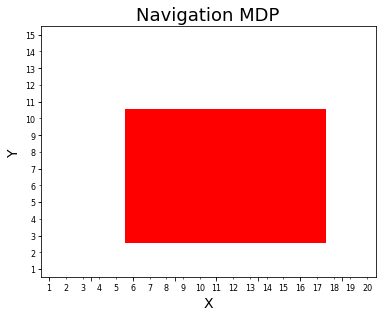

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1119fea58>)

In [4]:
np.random.seed(1)
torch.manual_seed(1)

obstacle = lambda x, y, w, h: [(x+i, y+j) for j in range(h) for i in range(w)]
nvmdp = NavigationWorldMDP(
    
    width = 20, height = 15,
    nav_cell_types = ['white', "red"],
    nav_cell_rewards = [-0.01, -10],
    nav_cell_p_or_locs = [1., obstacle(6,3,12,8)],
    goal_cell_types = [],
    goal_cell_rewards = [],
    goal_cell_locs = [],
    slip_prob = 0.0, step_cost = 0,
    gamma = 0.95
)
nvmdp.visualize_grid(goal_marker="")

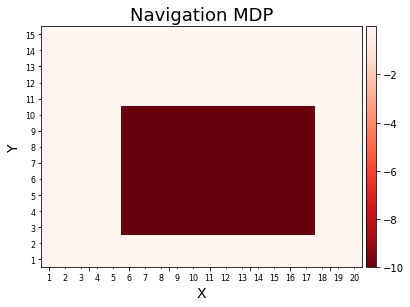

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x111dc8b70>)

In [5]:
S = nvmdp.get_all_states()
s_to_idx = {tuple(v):k for k,v in enumerate(S)}
R_s = nvmdp._reward_func_state_only
R = torch.tensor([R_s(s) for s in S], requires_grad=True)
R_grid = convert_to_grid(nvmdp, S, R)
A = nvmdp.get_actions()
a_to_idx = {a:i for i,a in enumerate(A)}
T = nvmdp.transition_func
nvmdp.visualize_grid(R_grid, state_space_cmap=False, cmap=plt.cm.Reds_r, show_colorbar=True, goal_marker="")

## Expert demonstrations

In [6]:
given_goal = (16,11)
Pi_expert, V_expert, Q_expert = value_iteration(S, A[:4], R, T, 0.95, 200, s_to_idx[given_goal], boltzmann_temp=0.001)

VI converged @ 25.


In [7]:
start_states = [(5,3)]
traj_list = sample_trajectories(10, S, A, T, start_states*10, Pi_expert, given_goal, 200, 
                                greedy_selection=True)

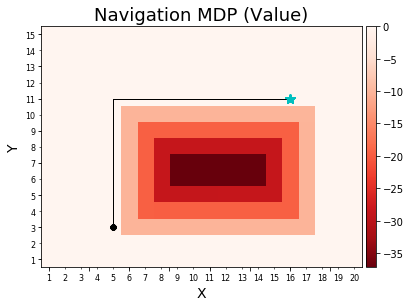

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1119f4668>)

In [8]:
V_grid = convert_to_grid(nvmdp, S, V_expert)
nvmdp.visualize_grid(V_grid, trajectories=list(zip(*traj_list))[0], 
                     state_space_cmap=False, cmap=plt.cm.Reds_r, 
                     show_colorbar=True, end_marker="*c", title="Navigation MDP (Value)")

Obstacle values look weird (not constant) because they can actually be entered as per current configuration of the MDP. We haven't modeled obstacles as walls, they are just navigable cells like others but with negative rewards. Ideally, we'll want them to be terminal states. For example,

```
goal_cell_types = ["red"],
goal_cell_rewards = [-10],
goal_cell_locs = [obstacle(10,1,5,20) + obstacle(20,11,5,20)],
```

But if we do so in IRL we can't learn about features of onstacles that are hidden behind 1 cell border. So we don't want terminal states in the actually MDP that we want to solve using IRL. If non-terminal obstacles bother in sampling trajectories, alternatively, one could use a separate MDP for sampling trajectories.

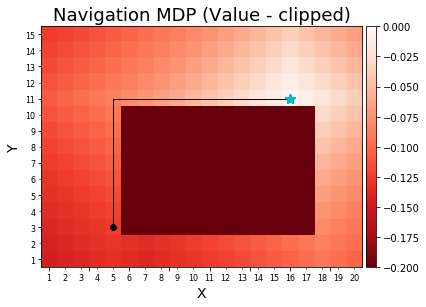

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11b232940>)

In [9]:
# Set vmin to better visualize V gradients
nvmdp.visualize_grid(V_grid, trajectories=list(zip(*traj_list))[0], vmin=-0.2,
                     state_space_cmap=False, cmap=plt.cm.Reds_r, 
                     show_colorbar=True, end_marker="*c", title="Navigation MDP (Value - clipped)")

# MLIRL gradient analysis

In [10]:
n_vi_iter = 200

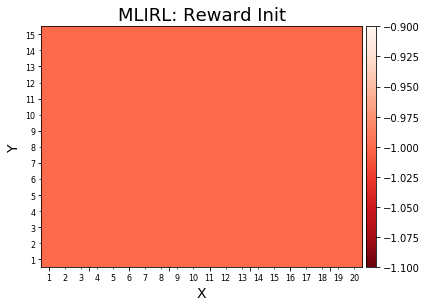

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11b463d30>)

In [11]:
np.random.seed(1)
torch.manual_seed(1)

# R_rand = np.random.normal(-2, 0.1, len(S))
R_const = -1 * np.ones(len(S))
R = R_const
nvmdp.visualize_grid(convert_to_grid(nvmdp, S, R), state_space_cmap=False, 
                     cmap=plt.cm.Reds_r, show_colorbar=True, title="MLIRL: Reward Init")

### Assume low temperature policy

In [12]:
boltzmann_temp = 0.1
R1 = torch.tensor(R_const, requires_grad=True)
Pi_low, V_low, Q_low = value_iteration(S, A, R1, T, 0.99, n_vi_iter, s_to_idx[given_goal],
                                       boltzmann_temp=boltzmann_temp)

VI converged @ 26.


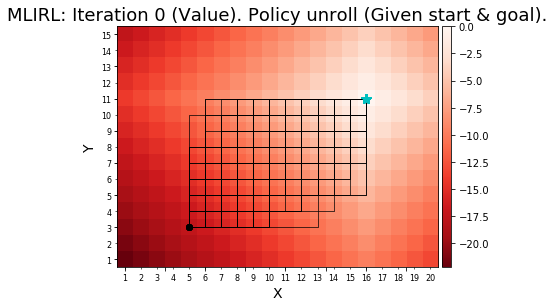

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11b446ef0>)

In [13]:
V_grid = convert_to_grid(nvmdp, S, V_low)
traj_list2 = sample_trajectories(100, S, A, T, start_states*100, Pi_low, 
                                 given_goal, 200, greedy_selection=False)
nvmdp.visualize_grid(V_grid, trajectories=list(zip(*traj_list2))[0],
                     state_space_cmap=False, cmap=plt.cm.Reds_r, 
                     show_colorbar=True, end_marker="*c", title="MLIRL: Iteration 0 (Value). Policy unroll (Given start & goal).")

In [14]:
ll = likelihood(Pi_low, traj_list, s_to_idx, a_to_idx)
nll = -ll
nll.backward(retain_graph=True)
convert_to_grid(nvmdp, S, -R1.grad).round(2)

array([[ 0.000e+00,  0.000e+00, -0.000e+00, -0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00, -0.000e+00, -0.000e+00],
       [ 0.000e+00,  0.000e+00, -0.000e+00,  0.000e+00, -0.000e+00,
        -0.000e+00, -0.000e+00, -0.000e+00, -0.000e+00, -0.000e+00,
        -0.000e+00, -0.000e+00, -0.000e+00, -0.000e+00, -0.000e+00,
        -0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00, -0.000e+00],
       [ 0.000e+00, -0.000e+00,  0.000e+00, -0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00, -0.000e+00,  0.000e+00, -0.000e+00, -0.000e+00],
       [-0.000e+00,  0.000e+00, -0.000e+00,  0.000e+00, -0.000e+00,
        -0.000e+00, -0.000e+00, -0.000e+00, -0.000e+00, -0.000e+00,
        -0.000e+00, -0.000e+00, -0.000e+00, -

**Understanding gradients**

If objective is loss = -loglikelihood:  
R grad positive => objective increases with R => loss increases => ll decreases  
R grad negative => objective decreases with R => loss decreases => ll increases

If objective is loglikelihood:  
R grad positive => objective increases with R => ll increases  
R grad negative => objective decreases with R => ll decreases

PyTorch optimizers take step in the negative direction of the gradient, that is, they try to minimize the objective function. So we'll use nll instead of ll (even though intuitively ll makes more sense). For easier visualization, we'll negate the gradients, so it's easier to infer gradients.

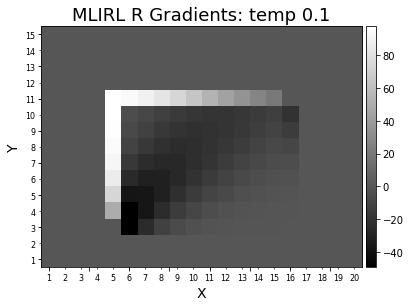

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11baf5908>)

In [15]:
nvmdp.visualize_grid(convert_to_grid(nvmdp, S, -R1.grad), state_space_cmap=False, 
                     cmap=plt.cm.gray, show_colorbar=True,
                     title="MLIRL R Gradients: temp {}".format(boltzmann_temp))

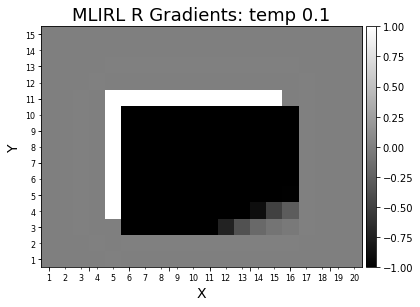

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11c677be0>)

In [16]:
nvmdp.visualize_grid(convert_to_grid(nvmdp, S, -R1.grad), state_space_cmap=False, 
                     cmap=plt.cm.gray, show_colorbar=True, vmax=1, vmin=-1,
                     title="MLIRL R Gradients: temp {}".format(boltzmann_temp))

### Assume high temperature policy

In [17]:
boltzmann_temp = 2.
R2 = torch.tensor(R_const, requires_grad=True)
Pi_high, V_high, Q_high = value_iteration(S, A, R2, T, 0.99, n_vi_iter, s_to_idx[given_goal],
                                       boltzmann_temp=boltzmann_temp)

VI converged @ 38.


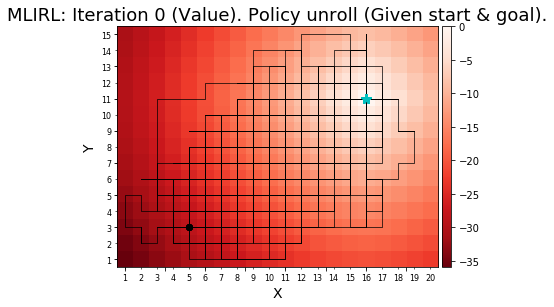

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11c7d3828>)

In [18]:
V_grid = convert_to_grid(nvmdp, S, V_high)

traj_list2 = sample_trajectories(100, S, A, T, start_states*100, Pi_high, given_goal, 200, greedy_selection=False)

nvmdp.visualize_grid(V_grid, trajectories=list(zip(*traj_list2))[0],
                     state_space_cmap=False, cmap=plt.cm.Reds_r, 
                     show_colorbar=True, end_marker="*c", title="MLIRL: Iteration 0 (Value). Policy unroll (Given start & goal).")

In [19]:
ll = likelihood(Pi_high, traj_list, s_to_idx, a_to_idx)
nll = -ll
nll.backward(retain_graph=True)

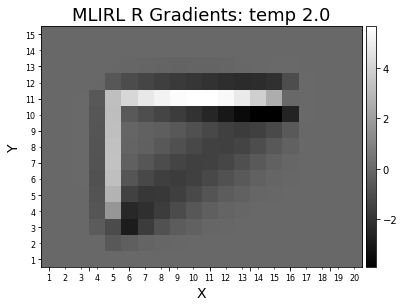

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11cc8dda0>)

In [20]:
nvmdp.visualize_grid(convert_to_grid(nvmdp, S, -R2.grad), state_space_cmap=False,
                     cmap=plt.cm.gray, show_colorbar=True, 
                     title="MLIRL R Gradients: temp {}".format(boltzmann_temp))

In [21]:
temp_list = [0.1, 0.4, 0.8, 1., 2., 4., 8., 10.]
# temp_list = np.exp(np.linspace(np.log(0.1), np.log(10)))
R_grad_list = {}

for temp in temp_list:
    
    print("Temp {}: computing policy...".format(temp))
    R = torch.tensor(R_const, requires_grad=True)
    Pi, V, Q = value_iteration(S, A, R, T, 0.95, n_vi_iter, s_to_idx[given_goal], boltzmann_temp=temp)
    print("Running backprop...")
    ll = likelihood(Pi, traj_list, s_to_idx, a_to_idx)
    (-ll).backward()
    R_grad_list["temp_" + str(temp)] = convert_to_grid(nvmdp, S, -R.grad.clone())

Temp 0.1: computing policy...
VI converged @ 27.
Running backprop...
Temp 0.4: computing policy...
VI converged @ 38.
Running backprop...
Temp 0.8: computing policy...
VI converged @ 38.
Running backprop...
Temp 1.0: computing policy...
VI converged @ 44.
Running backprop...
Temp 2.0: computing policy...
VI converged @ 67.
Running backprop...
Temp 4.0: computing policy...
VI converged @ 82.
Running backprop...
Temp 8.0: computing policy...
VI converged @ 86.
Running backprop...
Temp 10.0: computing policy...
VI converged @ 86.
Running backprop...


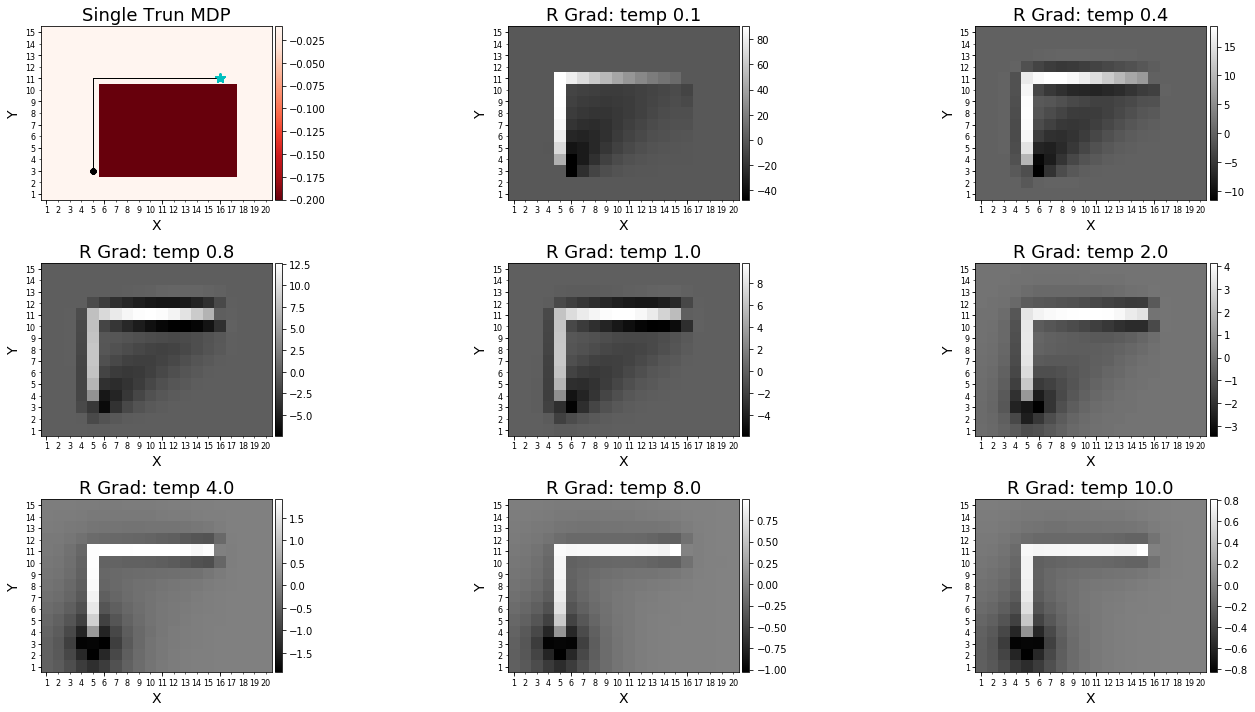

In [22]:
fig = plt.figure(figsize=(20,10))
fig, ax = nvmdp.visualize_grid(R_grid, trajectories=list(zip(*traj_list))[0], vmin=-0.2,
                     state_space_cmap=False, cmap=plt.cm.Reds_r, 
                     fig=fig, subplot_str="33" + str(1),
                     show_colorbar=True, end_marker="*c", title="Single Trun MDP")

for temp_idx in range(8):
    fig, ax = nvmdp.visualize_grid(R_grad_list["temp_"+ str(temp_list[temp_idx])], 
                              state_space_cmap=False,
                              cmap=plt.cm.gray, show_colorbar=True, 
                              fig=fig, subplot_str="33" + str(temp_idx+2),
                              title="R Grad: temp {}".format(temp_list[temp_idx]))
plt.tight_layout()

## Effect of temperature on gradients

In [23]:
# ---------------
# 3D surface plot 
# ---------------
def get_xyz(img_2d):
    
    x_list, y_list, z_list = [], [], []
    for row in range(len(img_2d)):
        for col in range(len(img_2d[0])):
            x, y = row, col
            x_list.append(x)
            y_list.append(y)
            z_list.append(img_2d[row, col])
    return x_list, y_list, z_list

def plot_3d_surface(img_2d, fig, cmap=plt.cm.jet):
    """
    Ref: https://python-graph-gallery.com/371-surface-plot/
    """
    X, Y, Z = get_xyz(img_2d)
    # ax = fig.add_subplot(122)
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(Y, X, Z, cmap=plt.cm.jet, linewidth=0.2)
    ax.set_zlim(-0.5, 0.5)
    
    ax.invert_yaxis()
    ax.view_init(25, -110)
    
    # to Add a color bar which maps values to colors.
    surf=ax.plot_trisurf(Y, X, Z, cmap=plt.cm.jet, linewidth=0.2)
    fig.colorbar(surf, shrink=0.5, aspect=5)

# ---------------
# GIF image source
# ---------------
def prepare_temp_grad_images(nvmdp, R_grid, expert_traj, 
                             R_grad_list, figsize=(40,20)):

    for temp, grad_img in R_grad_list.items():
        
        plt.close('all')
        fig = plt.figure(figsize=figsize)
        fig, ax = nvmdp.visualize_grid(R_grid, trajectories=expert_traj, cmap=plt.cm.gray,
                             state_space_cmap=False, show_colorbar=True, fig=fig, subplot_str="121",
                             title="IRL GridWorld", end_marker="")
        fig, ax = nvmdp.visualize_grid(grad_img, trajectories=expert_traj, 
                             state_space_cmap=False,  traj_marker='-b',
                             cmap=plt.cm.gray, show_colorbar=True, fig=fig, subplot_str="122",
                             title="MLIRL R Gradients. {}.".format(temp))
        
        
        yield read_pil_image_from_plt(plt)
        plt.clf()
        
def prepare_temp_grad_images_3d(nvmdp, R_grid, expert_traj, 
                             R_grad_list, figsize=(40,20)):

    v_min = np.min(list(R_grad_list.values()))
    v_max = np.max(list(R_grad_list.values()))
    normalize = lambda x: (x-v_min)/(v_max-v_min) - 0.5
    for temp, grad_img in R_grad_list.items():
        
        plt.close('all')
        fig = plt.figure(figsize=(14,14))
        plot_3d_surface(normalize(grad_img), fig, cmap=plt.cm.jet)
        plt.title("MLIRL R Gradients. {}.".format(temp.replace("_", " ")))
        yield read_pil_image_from_plt(plt)
        plt.clf()
        
def prepare_temp_images(nvmdp, expert_traj, R_grad_list):
    
    for temp, grad_img in R_grad_list.items():
        
        nvmdp.visualize_grid(grad_img, trajectories=expert_traj, 
                             state_space_cmap=False,  traj_marker='-b',
                             cmap=plt.cm.Reds_r, show_colorbar=True, new_fig=False, subplot_str="32" + str(3 + j),
                             title="MLIRL R Gradients. {}, temp: {}".format(temp))

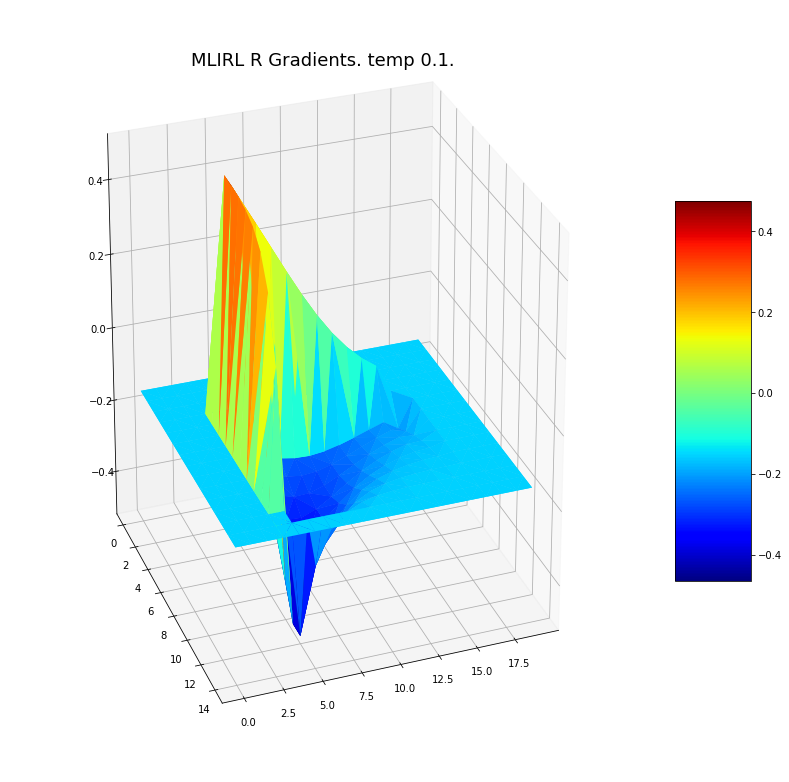

In [24]:
for x in prepare_temp_grad_images_3d(nvmdp, R_grid, list(zip(*traj_list))[0], R_grad_list):
    break

In [25]:
create_gif(lambda: prepare_temp_grad_images_3d(nvmdp, R_grid, list(zip(*traj_list))[0], R_grad_list),
           figsize=(30,45), fps=5, cmap=None, gif_name="./__gif__irl_one_obstacle__4_actions__mlirl_temp_effects_3d_normalized.gif")

<Figure size 1008x1008 with 0 Axes>

<img src="./__gif__irl_one_obstacle__4_actions__mlirl_temp_effects_3d_normalized.gif">